In [1]:
import scipy.io as sio
import numpy as np
from scipy.stats import multivariate_normal
from numpy import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
mat_contents = sio.loadmat('2_data.mat')
t = mat_contents['t']
X = mat_contents['x']

X_train = X[:60]
X_test = X[60:]
t_train = t[:60]
t_test= t[60:]

sort_idx = np.argsort(X_train, axis = 0).reshape(-1)
sorted_X = X[sort_idx]
sorted_t = t[sort_idx]

thetas = np.array([[1.0, 4.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 4.0, 0.0, 5.0], [1.0, 64.0, 10.0, 0.0]])

In [3]:
class Kernel(object):
    
    def __init__(self, theta_list):
        self.theta = theta_list
    
    def pmulti(self, x, xm):
        values = []
        for i in x:
            multiply = []
            for j in xm:
                multiply.append(i*j)
            values.append(multiply)
        return np.array(values)

    def pminus(self, x, xm):
        values = []
        for i in x:
            minus = []
            for j in xm:
                minus.append(i-j)
            values.append(minus)
        return np.array(values)**2
    
    def kernelFunction(self, x, xm, pairs = True):
        
        if pairs:
            values = self.pminus(x, xm)
            diff = self.theta[1] * values
            multi = self.pmulti(x, xm)
        else:
            diff = self.theta[1] * (x-xm) ** 2
            multi = x*xm

        funct = self.theta[0] * np.exp(-0.5 * diff) + self.theta[2] + self.theta[3]*multi
        
        return np.squeeze(funct, axis=(-1,))

    def findG(self, x, xm, pairs = True):
        if pairs:
            values = self.pminus(x, xm)
            
            dc = np.exp(-0.5 * self.theta[1] * values)
            dc1 =  -0.5 * self.theta[0] * values * np.exp(-0.5 * self.theta[1] * values)
            dc2 = np.ones_like(values)
            dc3 = self.pmulti(x, xm)
        
        else:
            dc = np.exp(-0.5 * self.theta[1] * (x - xm)**2)
            dc1 =  -0.5 * self.theta[0] * (x - xm)**2 * np.exp(-0.5 * self.theta[1] * (x - xm)**2)
            dc2 = np.ones_like(x)
            dc3 = x * xm

        return [np.squeeze(dc, axis=(-1,)), np.squeeze(dc1, axis=(-1,)), np.squeeze(dc2, axis=(-1,)), np.squeeze(dc3, axis=(-1,))]


In [4]:
def check(nparray):

    for i in nparray:
        if i > 6.0:
            return False
        return True

In [5]:
class GPRegression(object):

    def __init__(self, kernel):
        self.beta = 1.0
        self.kernel = kernel
        self.covariance = None
        self.precision = None

    def fit(self, X, t, iteration = 0, learning_rate = 0.1 , findgrad = False):

        
        self.X = X
        self.t = t
        self.t = self.t.reshape(-1,)
        
        I = np.eye(len(X))
        K = self.kernel.kernelFunction(X, X) # gram matrix
        self.covariance = K + I / self.beta 
        self.precision = np.linalg.inv(self.covariance)
        
        
        updates_list = []
        epochs = [] 

        theta_0 = []
        theta_1 = []
        theta_2 = []
        theta_3 = []
        
        
        if findgrad == False:
            return self.gaussianlike()
        else:

            best_loglike = -2000
            g_update  = np.array([1000,1000,1000,1000]) 
            i = 0
            while check(g_update) == False:
                
                gradi = self.kernel.findG(self.X, self.X)
                
                g_update  = []
                
                for g in gradi: 
                    tr_cov = - 0.5*np.trace(self.precision.dot(g))
                    targetcov = 0.5*( self.t.dot(self.precision.dot(g)).dot(self.precision).dot(self.t)) 
                    grad_theta = tr_cov + targetcov
                    g_update.append(grad_theta)
                    
                g_update = np.asarray(g_update, dtype = np.float32)
                print(g_update)
                updates_list.append(g_update)
                
                self.kernel.theta += learning_rate * g_update

                theta_0.append(self.kernel.theta[0])
                theta_1.append(self.kernel.theta[1])
                theta_2.append(self.kernel.theta[2])
                theta_3.append(self.kernel.theta[3])

                K = self.kernel.kernelFunction(X, X)
                self.covariance = K + I / self.beta
                self.precision = np.linalg.inv(self.covariance)

                loglike = self.gaussianlike()

                if loglike > best_loglike:
                    best_loglike = loglike
                    best_theta = [self.kernel.theta[0], self.kernel.theta[1], self.kernel.theta[2],self.kernel.theta[3]]
                else:
                    self.kernel.theta += learning_rate * g_update # update
                    learning_rate = learning_rate* 0.9
                
                epochs.append(i)
                i+=1
                
            return epochs, updates_list, [theta_0, theta_1, theta_2, theta_3], best_theta 

    def gaussianlike(self): 
        
        return -0.5*( np.linalg.slogdet(self.covariance)[1] + self.t.dot(self.precision).dot(self.t) + len(self.t) * np.log(2 * np.pi)) 

    def predict(self, data): 

        K = self.kernel.kernelFunction(data, self.X)
        mean = K.dot(self.precision).dot(self.t)
        variance = (self.kernel.kernelFunction(data, data, pairs = False) + 1 / self.beta - np.sum(K.dot(self.precision) * K, axis=1))
        return mean, np.sqrt(variance) 
       

# 3.1

# i & ii

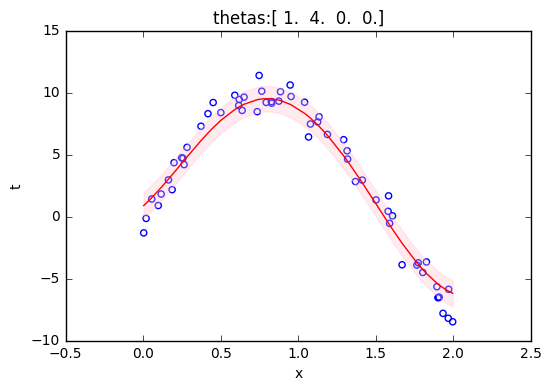

RMS Err Train: 1.052243074991517, RMS Err Test: 1.2987957582217342


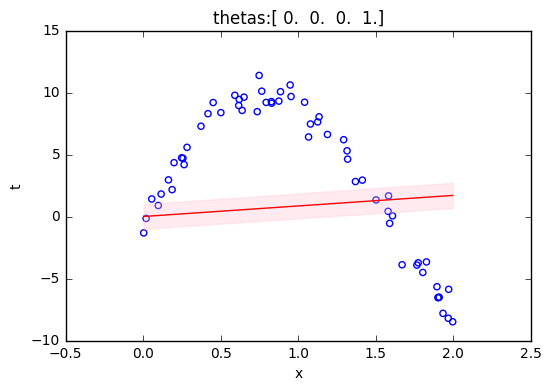

RMS Err Train: 6.657589544465414, RMS Err Test: 6.748539094668652


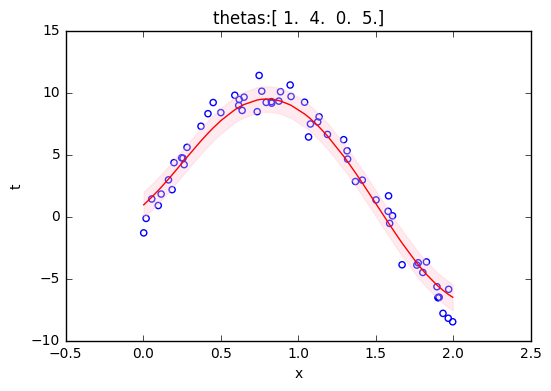

RMS Err Train: 1.0288404038224856, RMS Err Test: 1.2860902332963713


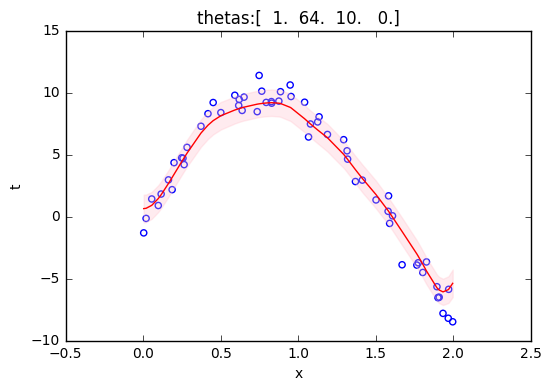

RMS Err Train: 1.0328772641056252, RMS Err Test: 1.3749015233630806


In [6]:
for i in range(len(thetas)):
    
    model = GPRegression(kernel = Kernel(theta_list = thetas[i] ))
    model.fit(X_train, t_train)
    
    sorted_y, sorted_y_std = model.predict(sorted_X) 
    
    RMS_train = np.power(np.mean((sorted_y - sorted_t.reshape(-1)) ** 2), 0.5)
    y_test, y_test_std = model.predict(X_test) 
    RMS_test = np.power(np.mean((y_test - t_test.reshape(-1)) ** 2), 0.5)
    
    plt.scatter(list(sorted_X), list(sorted_t), color="blue", edgecolor="b", facecolor="none",label="training")
    plt.plot(list(sorted_X), list(sorted_y), color="r", label="GPR")
    plt.fill_between(sorted_X.reshape(-1,), list(sorted_y - sorted_y_std), list(sorted_y + sorted_y_std), alpha=0.3, color="pink", label="std")
    plt.title("thetas:"+str(thetas[i]))
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()
    
    print("RMS Err Train: {}, RMS Err Test: {}".format(RMS_train, RMS_test))


# iii

1. theta0 and  theta1 play an important part for regression to fit real data. That's why theta_list [0,0,0,1]'s error is larger than others.
2. theta2's and theta3's impacts are smaller.

3. When theta1 becomes larger,  the error becomes larger, it is a little bit overfittting.
Theta [1,4,0,5] is the best result.

# 3.2

# i

# ii & iii

[ 7.50554848  0.47417831  0.10034751  0.01060299]
[  4.89247322e+00   2.73881406e-01   6.05867878e-02  -2.55229720e-03]


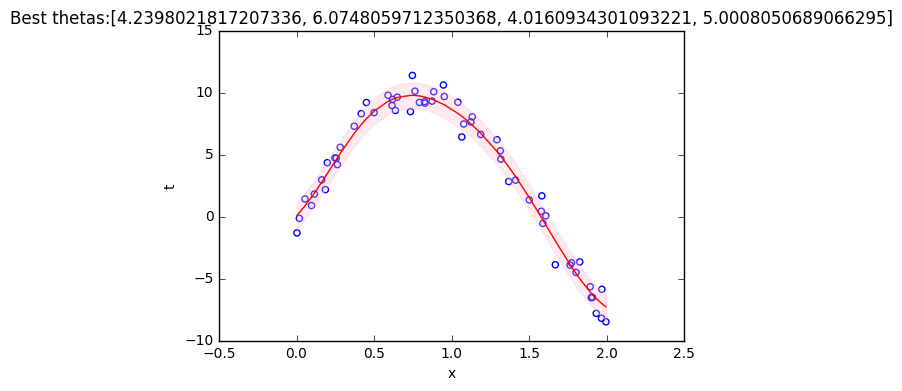

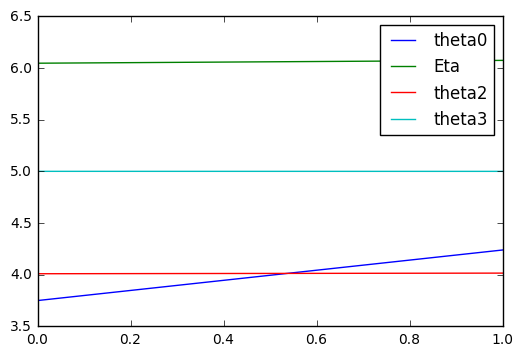

In [7]:
thetas2 = np.array([3.0, 6.0, 4.0, 5.0])
model = GPRegression(kernel = Kernel(theta_list = thetas2))
epochs, updates, update_thetas, bests_theta = model.fit(X_train, t_train, iteration = 25, findgrad = True) 

sorted_y, sorted_y_std = model.predict(sorted_X) 
plt.scatter(list(sorted_X), list(sorted_t), color="blue", edgecolor="b", facecolor="none",label="training")
plt.plot(list(sorted_X), list(sorted_y), color="r", label="GPR")
plt.fill_between(sorted_X.reshape(-1,), list(sorted_y - sorted_y_std), list(sorted_y + sorted_y_std), alpha=0.3, color="pink", label="std")

plt.title("Best thetas:"+ str(bests_theta))
plt.xlabel("x")
plt.ylabel("t")
plt.show()


plt.plot(epochs, update_thetas[0], label='theta0')
plt.plot(epochs, update_thetas[1], label='Eta')
plt.plot(epochs, update_thetas[2], label='theta2')
plt.plot(epochs, update_thetas[3], label='theta3')
plt.legend()
plt.show()

# iv

In [8]:
RMS_train = np.power(np.mean((sorted_y - sorted_t.reshape(-1)) ** 2), 0.5)
y_test, y_test_std = model.predict(X_test) 
RMS_test = np.power(np.mean((y_test - t_test.reshape(-1)) ** 2), 0.5)

print("RMS Err Train: {}, RMS Err Test: {}".format(RMS_train, RMS_test))

RMS Err Train: 0.8276395997022568, RMS Err Test: 1.1186281577797195


# v

### Bayesian linear regression

![title](./1.png)

![title](./2.png)

### The curve are almost thesame for distribution between these two regression.